# How large can my memory be while still maintaining less control resources than a memory-less system

In [9]:
import numpy as np 
import matplotlib.pyplot as plt


# RAM Surface Code Scaling with coherence time 
Consider gate time, and mode coherence

error correction cycle length \(t_{log}\). main error
error on physical qubit $$p = \frac{t_{log}}{T_{\text{coh},qub}}$$
error on memory $$p_{mem,idle} =  \frac{(N-1) *( t_{log} + 2t_{swap})}{T_{\text{coh},mem}}  $$
error on memory swap $$p_{mem, gate} = t_{swap}*(\frac{1}{T_{\text{coh}, mem}} + \frac{1}{T_{\text{coh}, qub}})$$
$$$$

Plots 
x axis: t1 qub
y axis : t1 mem 
z axis: lower bound on number of raqm/ upper 
two of these plots 

at error rate 1e-10

## Remember fundamental equations 
### memory less system 
$$\varepsilon = \left(\frac{p  }{p_{\text{threshold}}}\right)^{D}$$
### memory full system 
$$\varepsilon' = \left(\frac{p + p_{mem}}{p_{\text{threshold}}}\right)^{D'}$$

### Comparison of resources 
c = 3 (z + x + ancilla control)
$$(c+1)D'^2 <cND^2$$

In [167]:
def p_qubit(t_log_cycle, T_coh_qubit):
    '''
    $$p = \frac{t_{log}}{T_{\text{coh},qub}}$$
    '''
    return t_log_cycle / T_coh_qubit

def p_swap(t_swap, T_coh_cav, T_coh_qubit):
    '''
    2 total swaps, half in qubit, half in cavity
    $$p_{swap} = \frac{t_{swap}}{T_{\text{coh},cav}} + \frac{t_{swap}}{T_{\text{coh},qub}}$$
    '''
    return t_swap / T_coh_cav + t_swap / T_coh_qubit

def p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav):
    '''
    Time spent idle in memory is (N-1) * (t_log_cycle + 2*t_swap) / T_coh_cav
    # '''
    # print(f"Memory idle time: {(N-1) * (t_log_cycle + 2*t_swap)}")
    return (N-1) * (t_log_cycle + 2*t_swap) / T_coh_cav

def find_d_prime(vareps, t_log_cycle, t_swap, N, T_coh_cav, T_coh_qubit, p_threshold=0.01):
    # $$\varepsilon' = \left(\frac{p + p_{mem}}{p_{\text{threshold}}}\right)^{D'}$$
    
    # print(f"p_qubit: {p_qubit(t_log_cycle, T_coh_qubit)}")
    # print(f"p_mem_idle: {p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav)}")
    # print(f"p_swap: {p_swap(t_swap, T_coh_cav, T_coh_qubit)}")
    p = p_qubit(t_log_cycle, T_coh_qubit) + p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav) + p_swap(t_swap, T_coh_cav, T_coh_qubit)
    base = p/p_threshold

    if np.round(base,3)>=1: 
        return -1

    return np.log(vareps) / np.log(base)

def find_d(vareps, t_log_cycle, T_coh_qubit, p_threshold=0.01):
    
    # \varepsilon = \left(\frac{p}{p_{\text{threshold}}}\right)^{D}
    
    p = p_qubit(t_log_cycle, T_coh_qubit)
    base = p/p_threshold
    # print(f"p: {p}, base: {base}")

    if np.round(base,3)>=1: 
        return -1

    return np.log(vareps) / np.log(base)


# find the lowest N and highest N for which $$2D'^2 <ND^2$$
def find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit, p_threshold=0.01, N_min=1, N_max=500, c= 3):
    '''
    Find the lowest and highest N for which 2D'^2 < N D^2
    Returns (N_low, N_high) or (None, None) if no such N exists.
    '''
    D = find_d(vareps, t_log_cycle, T_coh_qubit, p_threshold)
    N_low, N_high = None, None
    for N in range(N_min, N_max+1):
        Dp = find_d_prime(vareps, t_log_cycle, t_swap, N, T_coh_cav, T_coh_qubit, p_threshold)
        # print(f"N={N}, D'={Dp}, D={D}, 2D'^2={2*Dp**2}, ND^2={N*(D**2)}")
        if Dp < 0 or D < 0:
            continue
        if (c+1)*Dp**2 < c*N*D**2:
            if N_low is None:
                N_low = N
            N_high = N
    return N_low, N_high

# Example usage:
vareps = 1e-10 # doesnt matter!
t_log_cycle = 2e-7 #https://arxiv.org/pdf/2408.13687v1 have 42 ns cz (check readout)
t_swap = 5e-7 #https://arxiv.org/abs/2303.00959 have 100 ns swaps
T_coh_cav = 10e-3
T_coh_qubit = 1e-3

# debug d' 
# Dp = find_d_prime(vareps, t_log_cycle, t_swap, 10, T_coh_cav, T_coh_qubit)
# print(f"D': {Dp}")

N_low, N_high = find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit)
print(f"Lowest N: {N_low}, Highest N: {N_high}")




Lowest N: 5, Highest N: 32


In [165]:
# now we vary t_coh_qubit (x axis) and t_coh_cav (y axis) and plot N_low and N_high
T_coh_qubit_vals = np.logspace(-4, -1, 100)
T_coh_cav_vals = np.logspace(-3, -1, 100)

N_low_vals = []
N_high_vals = []

for T_coh_qubit in T_coh_qubit_vals:
    for T_coh_cav in T_coh_cav_vals:
        N_low, N_high = find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit)
        if N_low is None:
            N_low = np.nan
        if N_high is None:
            N_high = np.nan
        N_low_vals.append(N_low)
        N_high_vals.append(N_high)



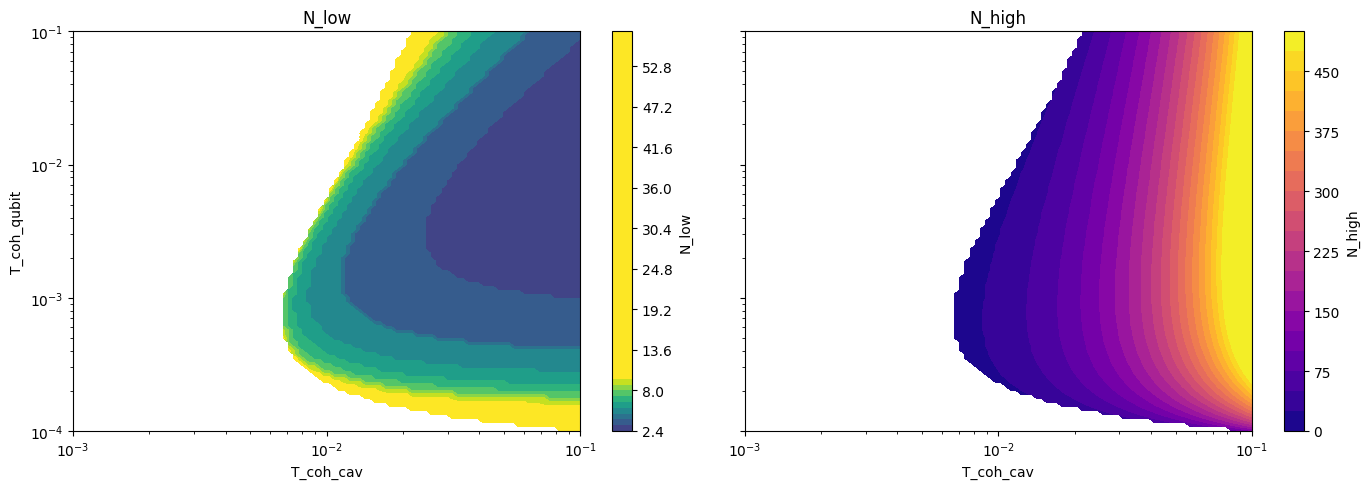

In [166]:
# Reshape results for plotting
N_low_vals = np.array(N_low_vals).reshape(len(T_coh_qubit_vals), len(T_coh_cav_vals))
N_high_vals = np.array(N_high_vals).reshape(len(T_coh_qubit_vals), len(T_coh_cav_vals))


# Plot contours of N_low and N_high
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# N_low contour
c0 = axs[0].contourf(T_coh_cav_vals, T_coh_qubit_vals, N_low_vals, levels=80, cmap='viridis')
axs[0].set_title('N_low')
axs[0].set_xlabel('T_coh_cav')
axs[0].set_ylabel('T_coh_qubit')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig.colorbar(c0, ax=axs[0], label='N_low')
# recale colorbar to be max of 5
c0.set_clim(1, 10)

# N_high contour
c1 = axs[1].contourf(T_coh_cav_vals, T_coh_qubit_vals, N_high_vals, levels=20, cmap='plasma')
axs[1].set_title('N_high')
axs[1].set_xlabel('T_coh_cav')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
fig.colorbar(c1, ax=axs[1], label='N_high')

plt.tight_layout()
plt.show()




In [124]:
N_low_vals

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 3, 3, 3],
       [nan, nan, nan, ..., 3, 3, 3],
       [nan, nan, nan, ..., 3, 3, 3]], dtype=object)

In [121]:
np.min(N_low_vals)

nan

In [72]:
T_coh_cav_vals

array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02, 1.23284674e-02,
       1.35304777e-02, 1.48496826e-02, 1.62975083e-02, 1.78864953e-02,
       1.96304065e-02, 2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02, 3.76493581e-02,
       4.13201240e-02, 4.53487851e-02, 4.97702356e-02, 5.46227722e-02,
       5.99484250e-02, 6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.04761575e-01, 1.14975700e-01,
       1.26185688e-01, 1.38488637e-01, 1.51991108e-01, 1.66810054e-01,
      

## RAM surface code scaling
$$\varepsilon' = \left(\frac{p + 2Np_{\text{swap}}/8}{p_{\text{threshold}}}\right)^{D'}$$

Control Resources per logical qubit $r = 2D'^2 /N$



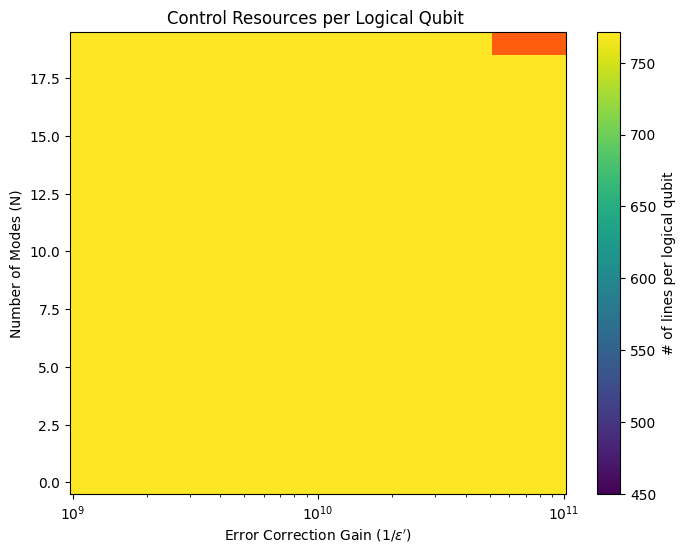

In [52]:
def D_prime(vareps_prime, N, p_swap = 0.001, p_threshold = 0.01, p = 0.005):    
    # Solve for D' in terms of vareps_prime and N
    # vareps_prime = ((p + 2*N*p_swap/8) / p_threshold) ** D'
    # Take log on both sides:
    # log(vareps_prime) = D' * log((p + 2*N*p_swap/8) / p_threshold)
    # D' = log(vareps_prime) / log((p + 2*N*p_swap/8) / p_threshold)
    # p = 0.01
    # p_swap = 0.005
    # p_threshold = 0.1
    base = (p + 2 * N * p_swap / 8) / p_threshold

    if base>1: 
        return 100000

    return np.log(vareps_prime) / np.log(base)



def plot_control_resources(vareps_prime_vals, N_vals, D_prime_func):
    import matplotlib.colors as mcolors

    # Compute Z as before
    X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Dp = D_prime_func(1/X[i, j], Y[i, j])
            if Y[i, j] == 0:
                Z[i, j] = 2 * Dp**2
            else:
                Z[i, j] = 2 * Dp**2 / Y[i, j]

    # Create a masked array for values > 500
    Z_masked = np.ma.masked_where(Z <= 100000, Z)

    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmin=Z.min(), vmax=500))
    plt.pcolormesh(X, Y, Z_masked, shading='auto', cmap=mcolors.ListedColormap(['red']), alpha=0.6)
    plt.xscale('log')
    plt.xlabel("Error Correction Gain ($1/\\varepsilon'$)")
    plt.ylabel("Number of Modes (N)")
    plt.title("Control Resources per Logical Qubit ")
    plt.colorbar(c, label="# of lines per logical qubit")
    plt.show()

N_vals = np.arange(0, 20,1)
vareps_prime_vals = np.logspace(-11, -9, 100)
plot_control_resources(vareps_prime_vals, N_vals, D_prime)
# plt.xscale('log')

In [53]:
 

def D_prime(vareps_prime, N, p_swap = 0.001, p_threshold = 0.01, p = 0.005):    
    # Solve for D' in terms of vareps_prime and N
    # vareps_prime = ((p + 2*N*p_swap/8) / p_threshold) ** D'
    # Take log on both sides:
    # log(vareps_prime) = D' * log((p + 2*N*p_swap/8) / p_threshold)
    # D' = log(vareps_prime) / log((p + 2*N*p_swap/8) / p_threshold)
    # p = 0.01
    # p_swap = 0.005
    # p_threshold = 0.1
    base = (p + 2 * N * p_swap / 8) / p_threshold

    if base>1: 
        return 500

    return np.log(vareps_prime) / np.log(base)



def plot_control_resources(vareps_prime_vals, N_vals, D_prime_func):
    import matplotlib.colors as mcolors

    # Compute Z as before
    X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Dp = D_prime_func(1/X[i, j], Y[i, j])
            if Y[i, j] == 0:
                Z[i, j] = 2 * Dp**2
            else:
                Z[i, j] = 2 * Dp**2 / Y[i, j]

    # Create a masked array for values > 500
    Z_masked = np.ma.masked_where(Z <= 500, Z)

    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmin=Z.min(), vmax=500))
    plt.pcolormesh(X, Y, Z_masked, shading='auto', cmap=mcolors.ListedColormap(['red']), alpha=0.6)
    plt.xscale('log')
    plt.xlabel("Error Correction Gain ($1/\\varepsilon'$)")
    plt.ylabel("Number of Modes (N)")
    plt.title("Control Resources per Logical Qubit ")
    plt.colorbar(c, label="# of lines per logical qubit")
    plt.show()


# I  want a table of color plots  with x axis being p swap and y axis being p 
# us the functions below
# Define ranges for p_swap and p
p_swap_vals = np.linspace(0.0001, 0.01, 4)
p_vals = np.linspace(0.001, 0.02, 4)

fig, axes = plt.subplots(len(p_vals), len(p_swap_vals), figsize=(16, 12), sharex=True, sharey=True)

for i, p in enumerate(p_vals):
    for j, p_swap in enumerate(p_swap_vals):
        def D_prime_custom(vareps_prime, N):
            base = (p + 2 * N * p_swap / 8) / 0.01  # p_threshold fixed at 0.01
            if base > 1:
                return 500
            return np.log(vareps_prime) / np.log(base)
        
        X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
        Z = np.zeros_like(X)
        for m in range(X.shape[0]):
            for n in range(X.shape[1]):
                Dp = D_prime_custom(1/X[m, n], Y[m, n])
                if Y[m, n] == 0:
                    Z[m, n] = 2 * Dp**2
                else:
                    Z[m, n] = 2 * Dp**2 / Y[m, n]
        Z_masked = np.ma.masked_where(Z <= 500, Z)
        ax = axes[i, j]
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', vmin=Z.min(), vmax=500)
        ax.pcolormesh(X, Y, Z_masked, shading='auto', cmap=plt.cm.Reds, alpha=0.6)
        ax.set_xscale('log')
        if i == len(p_vals) - 1:
            ax.set_xlabel("$1/\\varepsilon'$")
        if j == 0:
            ax.set_ylabel("N")
        ax.set_title(f"p={p:.3g}, p_swap={p_swap:.4f}")

fig.suptitle("Control Resources per Logical Qubit for varying p and p_swap", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.colorbar(c, ax=axes, orientation='vertical', label="# of lines per logical qubit")
plt.show()

# N_vals = np.arange(0, 10,1)
# vareps_prime_vals = np.logspace(-5, -1, 100)
# plot_control_resources(vareps_prime_vals, N_vals, D_prime)
# plt.xscale('log')

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 1600x1200 with 17 Axes>

# Google Comparison

In [44]:
import pandas as pd

# Create the data as a list of dictionaries
# Google 2025 results
data = [
    {"Component": "CZ gates", "p(i)": 2.8e-3, "expt wi": 65, "1/Λ contrib.": 0.182, "Percent": "41%"},
    {"Component": "CZ crosstalk", "p(i)": 5.5e-4, "expt wi": 91, "1/Λ contrib.": 0.05, "Percent": "11%"},
    {"Component": "CZ leakage", "p(i)": 2.0e-4, "expt wi": 108, "1/Λ contrib.": 0.022, "Percent": "5%"},
    {"Component": "Data qubit idle", "p(i)": 0.9e-2, "expt wi": 10, "1/Λ contrib.": 0.09, "Percent": "20%"},
    {"Component": "Readout", "p(i)": 0.8e-2, "expt wi": 6, "1/Λ contrib.": 0.048, "Percent": "11%"},
    {"Component": "Reset", "p(i)": 1.5e-3, "expt wi": 6, "1/Λ contrib.": 0.009, "Percent": "2%"},
    {"Component": "SQ gates", "p(i)": 6.2e-4, "expt wi": 63, "1/Λ contrib.": 0.039, "Percent": "9%"},
    {"Component": "Leakage (heating)", "p(i)": 2.5e-4, "expt wi": 18, "1/Λ contrib.": 0.005, "Percent": "1%"},
]

# Create DataFrame
df_components = pd.DataFrame(data)
df_components

,Component,p(i),expt wi,1/Λ contrib.,Percent
0,CZ gates,0.00280,65,0.182,41%
1,CZ crosstalk,0.00055,91,0.050,11%
2,CZ leakage,0.00020,108,0.022,5%
3,Data qubit idle,0.00900,10,0.090,20%
4,Readout,0.00800,6,0.048,11%
5,Reset,0.00150,6,0.009,2%
6,SQ gates,0.00062,63,0.039,9%
7,Leakage (heating),0.00025,18,0.005,1%


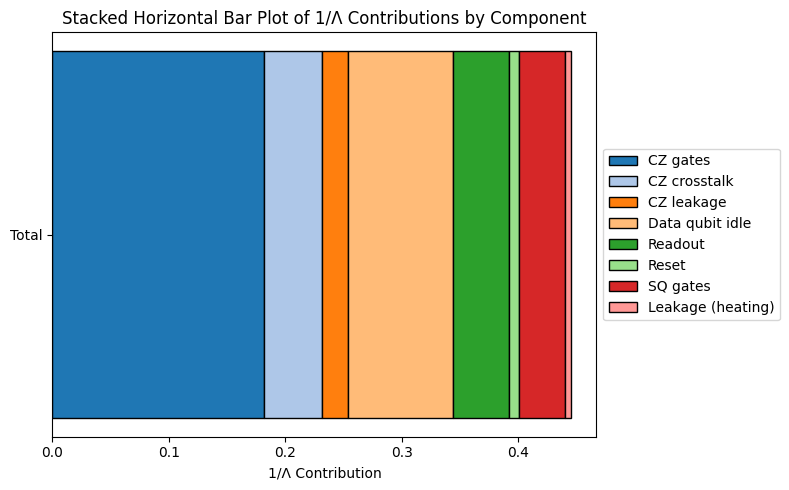

In [45]:
# mkae a stacked bar plot with 1/lambda contributions
# Stacked bar plot for 1/Λ contributions
# Single bar with each segment colored differently (not stacked, but grouped)
# Horizontal stacked bar plot for 1/Λ contributions
fig, ax = plt.subplots(figsize=(8, 5))

# Values and labels
contribs = df_components['1/Λ contrib.'].values
labels = df_components['Component'].values

# Choose colors (use first N from colors)
bar_colors = colors[:len(contribs)]

# Draw horizontal stacked bar (single bar, stacked segments)
left = 0
for val, label, color in zip(contribs, labels, bar_colors):
    ax.barh(0, val, left=left, color=color, edgecolor='black', height=0.5, label=label)
    left += val

ax.set_yticks([0])
ax.set_yticklabels(['Total'])
ax.set_xlabel('1/Λ Contribution')
ax.set_title('Stacked Horizontal Bar Plot of 1/Λ Contributions by Component')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Now we add different memory sizes 

$$T_q = 119 \mu s$$
$$T_m = 1 \textrm{ms}$$
$$t_{log} = 1.1 \mu s$$
$$t_{swap} = 2 \mu s$$


error on memory $$p_{mem,idle} =  \frac{(N-1) *( t_{log} + 2t_{swap})}{T_{\text{coh},mem}}  $$
error on memory swap $$p_{mem, gate} = t_{swap}*(\frac{1}{T_{\text{coh}, mem}} + \frac{1}{T_{\text{coh}, qub}})$$

$$p_{mem} = p_{mem, idle} + p_{mem, gate}$$

In [61]:
def compute_p_mem(N, t_log=1.1e-6, t_swap=2.639e-6, T_coh_mem = 0.61799e-3, T_coh_qub = 0.119e-3):
    """
    Compute p_mem for different N.
    p_mem = p_mem_idle + p_mem_gate
    p_mem_idle = ((N-1) * (t_log + 2*t_swap)) / T_coh_mem
    p_mem_gate = t_swap * (1/T_coh_mem + 1/T_coh_qub)
    Returns: array of p_mem for each N
    """
    N = np.asarray(N)
    p_mem_idle = ((N - 1) * (t_log + 2 * t_swap)) / T_coh_mem
    p_mem_gate = t_swap * (1 / T_coh_mem + 1 / T_coh_qub)
    return p_mem_idle + p_mem_gate

In [62]:
# RAQM Experiment
compute_p_mem(N = 7, t_log = 0, T_coh_qub = 100e-6, T_coh_mem=0.3e-3)

0.1407466666666667

In [63]:
# coherence times mean of all modes 
# \hline
# 		    \hline
# 		    $\Phi_{\text{dc}}=0.269\pi$  & Symbol & Frequency/$2\pi$ (GHz) & $T_{1} \left(\mu \text{s}\right)$ & $T_{R} \left(\mu \text{s}\right)$ & $T_{\rm echo} \left(\mu \text{s}\right)$ \\  \hline
#              Qubit ($Q$) & $\omega_{q}$ & $3.568$ & $493\pm13.1$ & $259\pm8.0$ & $370\pm14$  \\ \hline
#              Coupler ($C$) & $\omega_{c}$ & $4.037$ & $45\pm0.8$ & $0.39\pm0.04$ &   \\ \hline
# 		     Buffer 1 & $\omega_{b1}$ & $4.984$ & $209\pm5.1$ & $75.5\pm3.8$ & $219\pm7.0$   \\ 
#              Buffer 2 & $\omega_{b2}$ & $5.158$ & $120\pm1.3$ & $70.6\pm5.4$ & $193\pm6.7$  \\ \hline
#              Storage 1 & $\omega_{s1}$ & $5.333$ & $358.3\pm6.0$ & $235.7\pm7.1$ & $551.6\pm16.8$  \\ 
#              Storage 2 & $\omega_{s2}$ & $5.505$ & $1254.8\pm30.2$ & $378.3\pm15.1$ & $1493.2\pm53.5$  \\ 
#              Storage 3 & $\omega_{s3}$ & $5.681$ & $799.0\pm12.7$ & $677.2\pm16.8$ & $1309.9\pm41.8$  \\
#              Storage 4 & $\omega_{s4}$ & $5.860$ & $597.4\pm11.9$ & $806.2\pm23.7$ & $972.4\pm29.8$  \\
#              Storage 5 & $\omega_{s5}$ & $6.037$ & $355.7\pm5.5$ & $591.8\pm15.2$ & $663.3\pm22.7$  \\
#              Storage 6 & $\omega_{s6}$ & $6.229$ & $589.5\pm12.9$ & $1071.1\pm63.0$ & $1048.4\pm54.1$  \\
#              Storage 7 & $\omega_{s7}$ & $6.407$ & $371.2\pm6.4$ & $663.5\pm29.0$ & $692.7\pm22.7$  \\
#              \hline
#              Dump 1 & $\omega_{d1}$ & $7.297$ & $0.73\pm0.03$ &  &   \\
#              Dump 2 & $\omega_{d2}$ & $7.252$ & $1.81\pm0.11$ &  &   \\
#              \hline
#              Readout ($R$) & $\omega_{r}$ & $8.051$ & $0.05\pm0.01$ &  &   \\
#              \hline\hline
# Extract storage mode coherence times (T1 and Tphi) from the table above (in microseconds)
storage_T1s = np.array([
    358.3,   # Storage 1
    1254.8,  # Storage 2
    799.0,   # Storage 3
    597.4,   # Storage 4
    355.7,   # Storage 5
    589.5,   # Storage 6
    371.2    # Storage 7
])

# For Tphi, use T_echo as listed in the table
storage_Tphi = np.array([
    551.6,   # Storage 1 (T_echo)
    1493.2,  # Storage 2 (T_echo)
    1309.9,  # Storage 3 (T_echo)
    972.4,   # Storage 4 (T_echo)
    663.3,   # Storage 5 (T_echo)
    1048.4,  # Storage 6 (T_echo)
    692.7    # Storage 7 (T_echo)
])

mean_storage_T1 = np.mean(storage_T1s)
print(f"Mean Storage T1: {mean_storage_T1:.2f} us")


Mean Storage T1: 617.99 us


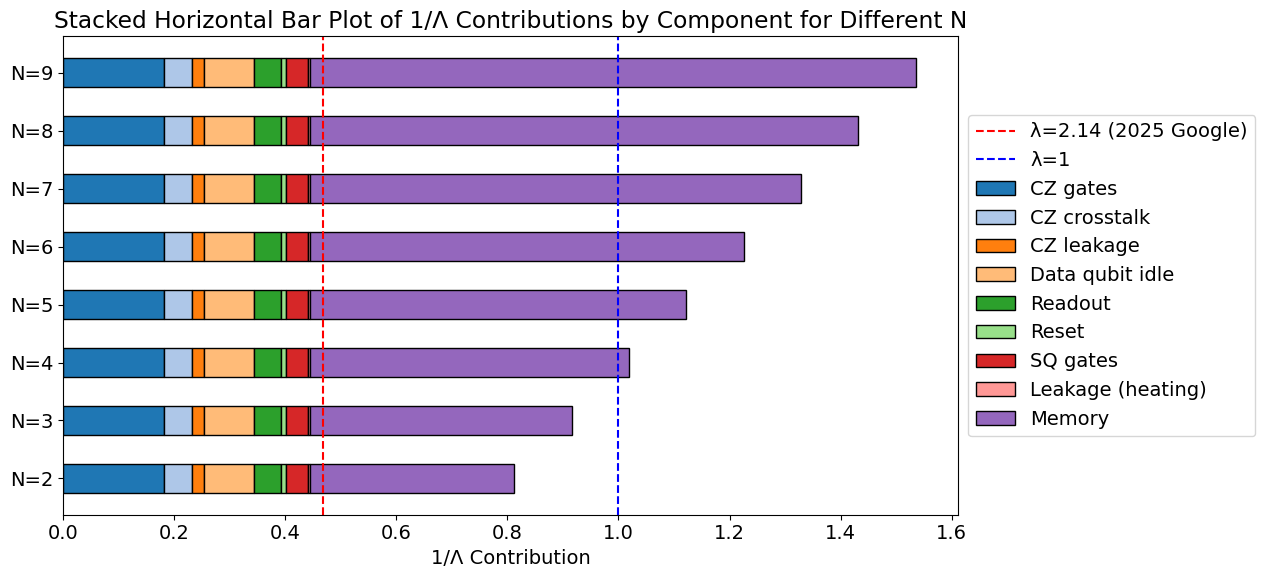

In [64]:
# Use the same weight as 'Data qubit idle' (expt wi = 10)
expt_wi_idle = df_components.loc[df_components['Component'] == 'Data qubit idle', 'expt wi'].values[0]

# Now cretae a stacked bar plot with 1/lambda contributions. each new horizontal bar is for a different N. 
fig, ax = plt.subplots(figsize=(10, 6))
mem_Ns = range(2, 10)

for N in mem_Ns:
    # Compute p_mem for this N
    p_mem = compute_p_mem(N)
    
    # Update the 'Data qubit idle' contribution
    df_temp = df_components.copy()
    # memory error  contribution  add a new component 
    data_copy = data.copy()
    data_copy.append({"Component": f"Memory", "p(i)": p_mem, "expt wi": expt_wi_idle, "1/Λ contrib.": p_mem * expt_wi_idle, "Percent": ""})
    df_temp = pd.DataFrame(data_copy)

    # plot the horizontal stacked bar
    contribs = df_temp['1/Λ contrib.'].values
    labels = df_temp['Component'].values
    bar_colors = colors[:len(contribs)]
    left = 0
    for val, label, color in zip(contribs, labels, bar_colors):
        ax.barh(N, val, left=left, color=color, edgecolor='black', height=0.5, label=label if N==2 else "")
        left += val
ax.set_yticks(mem_Ns)
ax.set_yticklabels([f'N={N}' for N in mem_Ns])
ax.set_xlabel('1/Λ Contribution')
ax.set_title('Stacked Horizontal Bar Plot of 1/Λ Contributions by Component for Different N')



# add vertyyicla line 
# \,lambda = 2.14 
ax.axvline(x=1/2.14, color='red', linestyle='--', label='λ=2.14 (2025 Google)')
# lambda = 1 
ax.axvline(x=1/1, color='blue', linestyle='--', label='λ=1')
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [65]:
df_components['1/Λ contrib.'] / df_components['1/Λ contrib.'].sum() * 100

0    40.898876
1    11.235955
2     4.943820
3    20.224719
4    10.786517
5     2.022472
6     8.764045
7     1.123596
Name: 1/Λ contrib., dtype: float64

In [66]:
df_components

,Component,p(i),expt wi,1/Λ contrib.,Percent
0,CZ gates,0.00280,65,0.182,41%
1,CZ crosstalk,0.00055,91,0.050,11%
2,CZ leakage,0.00020,108,0.022,5%
3,Data qubit idle,0.00900,10,0.090,20%
4,Readout,0.00800,6,0.048,11%
5,Reset,0.00150,6,0.009,2%
6,SQ gates,0.00062,63,0.039,9%
7,Leakage (heating),0.00025,18,0.005,1%


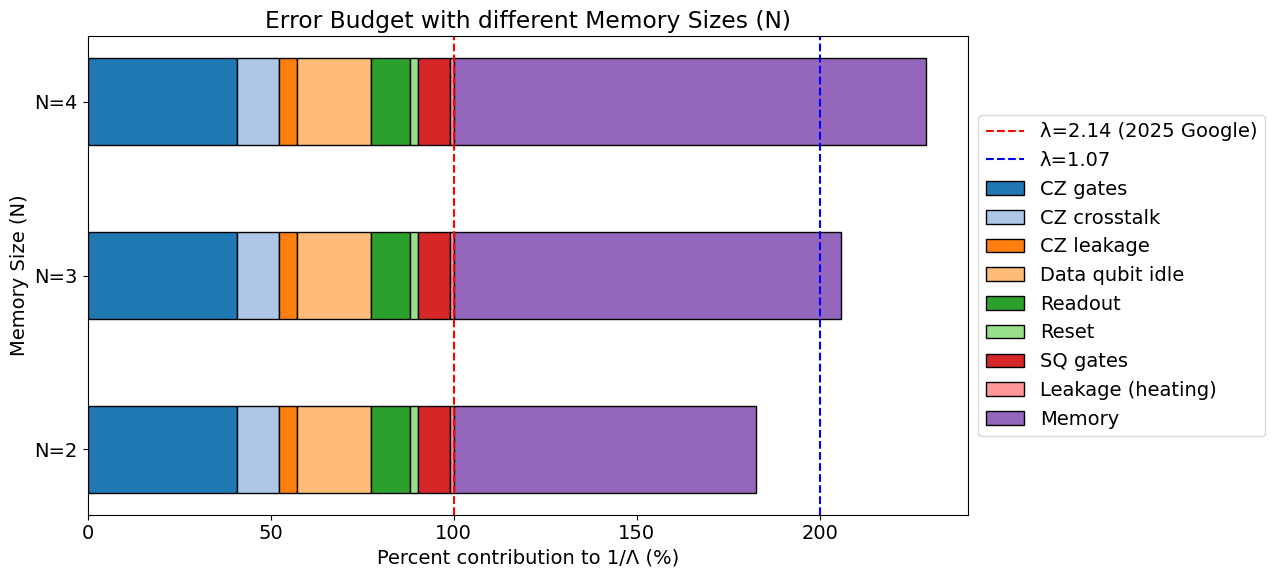

In [67]:
# Use the same weight as 'Data qubit idle' (expt wi = 10)
# increase fonts for better visibility
plt.rcParams.update({'font.size': 14})

expt_wi_idle = df_components.loc[df_components['Component'] == 'Data qubit idle', 'expt wi'].values[0]

# Now cretae a stacked bar plot with 1/lambda contributions. each new horizontal bar is for a different N. 
fig, ax = plt.subplots(figsize=(10, 6))
mem_Ns = range(2, 5)

for N in mem_Ns:
    # Compute p_mem for this N
    p_mem = compute_p_mem(N)
    
    # Update the 'Data qubit idle' contribution
    df_temp = df_components.copy()
    # memory error  contribution  add a new component 
    data_copy = data.copy()
    data_copy.append({"Component": f"Memory", "p(i)": p_mem, "expt wi": expt_wi_idle, "1/Λ contrib.": p_mem * expt_wi_idle, "Percent": ""})
    df_temp = pd.DataFrame(data_copy)

    # Compute the percent contribution
    df_temp['Percent'] = df_temp['1/Λ contrib.'] / df_components['1/Λ contrib.'].sum() * 100

    # plot the horizontal stacked bar
    percent_contribs = df_temp['Percent'].values
    labels = df_temp['Component'].values
    bar_colors = colors[:len(contribs)]
    left = 0
    for val, label, color in zip(percent_contribs, labels, bar_colors):
        ax.barh(N, val, left=left, color=color, edgecolor='black', height=0.5, label=label if N==2 else "")
        left += val
ax.set_yticks(mem_Ns)
ax.set_yticklabels([f'N={N}' for N in mem_Ns])
ax.set_ylabel('Memory Size (N)')
ax.set_xlabel('Percent contribution to 1/Λ (%)')
ax.set_title('Error Budget with different Memory Sizes (N)')



# add vertyyicla line 
# \,lambda = 2.14 
ax.axvline(x=100, color='red', linestyle='--', label='λ=2.14 (2025 Google)')
# lambda = 1 
ax.axvline(x=200, color='blue', linestyle='--', label='λ=1.07')
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# save figure
plt.savefig('rebuttal_google_error_budget_memory_sizes.png', bbox_inches='tight', dpi = 1000)


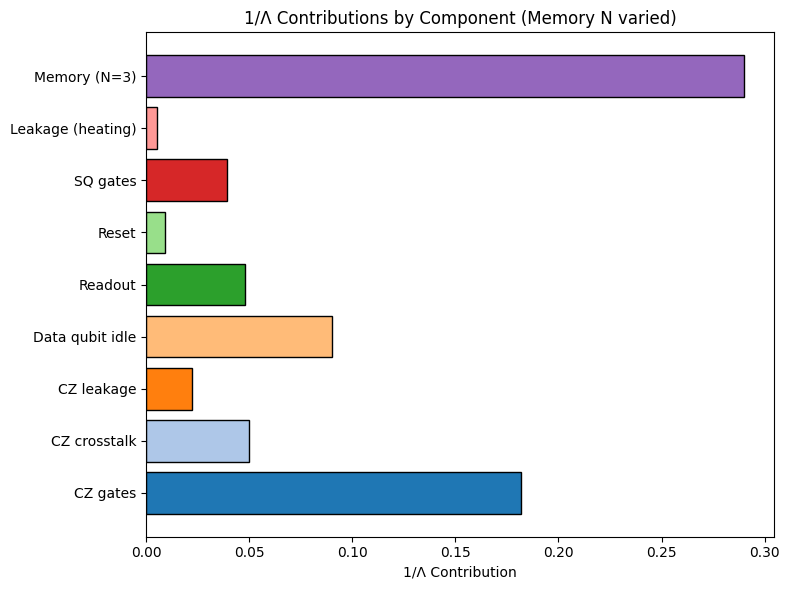

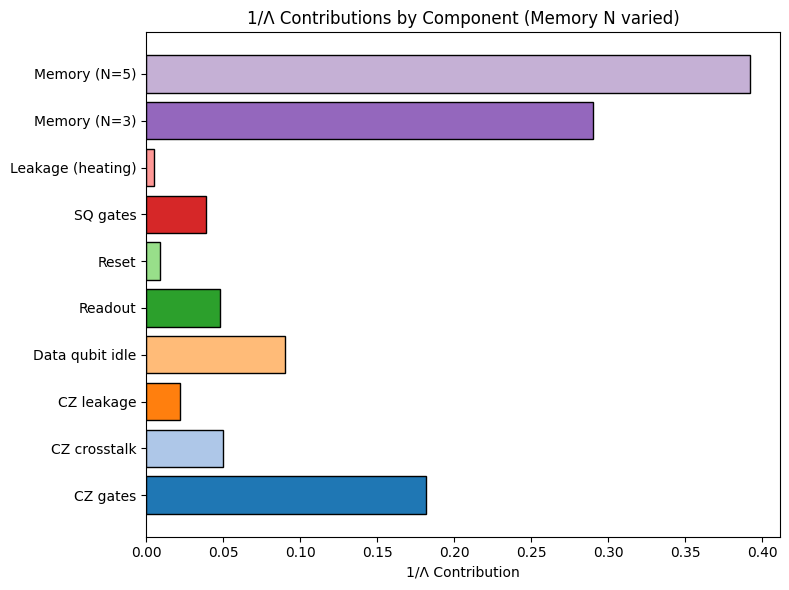

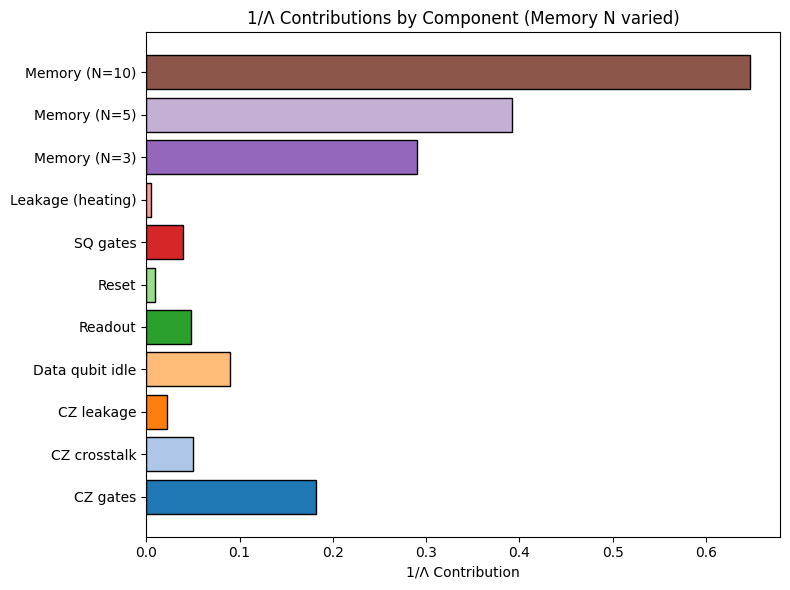

In [ ]:


# add p mem with weight same as time of sata qubit idle to the table and plot bars for N = 3, 5, 10
# Add p_mem as a new row to the table for N = 3, 5, 10
N_list = [3, 5, 10]
p_mem_vals = compute_p_mem(N_list)


for N, p_mem in zip(N_list, p_mem_vals):
    df_components = pd.concat([
        df_components,
        pd.DataFrame([{
            "Component": f"Memory (N={N})",
            "p(i)": p_mem,
            "expt wi": expt_wi_idle,
            "1/Λ contrib.": p_mem * expt_wi_idle,
            "Percent": ""
        }])
    ], ignore_index=True)

    # Plot horizontal bar plot with y axis as N (for memory rows), others as single bar
    import matplotlib.pyplot as plt

    # Separate original components and memory components
    orig_df = df_components[~df_components['Component'].str.startswith('Memory')]
    mem_df = df_components[df_components['Component'].str.startswith('Memory')]

    # Prepare y labels and values
    y_labels = list(orig_df['Component']) + list(mem_df['Component'])
    bar_vals = list(orig_df['1/Λ contrib.']) + list(mem_df['1/Λ contrib.'])

    # Assign colors (reuse bar_colors and colors as needed)
    all_colors = list(bar_colors) + list(colors[len(bar_colors):len(bar_colors)+len(mem_df)])
    fig, ax = plt.subplots(figsize=(8, 6))
    y_pos = np.arange(len(y_labels))

    ax.barh(y_pos, bar_vals, color=all_colors[:len(y_labels)], edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('1/Λ Contribution')
    ax.set_title('1/Λ Contributions by Component (Memory N varied)')
    plt.tight_layout()
    plt.show()

In [ ]:
#

import numpy as n